<a href="https://colab.research.google.com/github/fourmodern/toc_tutorial_colab/blob/main/teachopencadd/t043_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Title: Drug Molecule Generation with VAE
Author: [Victor Basu](https://www.linkedin.com/in/victor-basu-520958147)
Date created: 2022/03/10
Last modified: 2022/03/24
Description: Implementing a Convolutional Variational AutoEncoder (VAE) for Drug Discovery.
Accelerator: GPU

"""
## Introduction

In this example, we use a Variational Autoencoder to generate molecules for drug discovery.
We use the research papers
[Automatic chemical design using a data-driven continuous representation of molecules](https://arxiv.org/abs/1610.02415)
and [MolGAN: An implicit generative model for small molecular graphs](https://arxiv.org/abs/1805.11973)
as a reference.

The model described in the paper **Automatic chemical design using a data-driven
continuous representation of molecules** generates new molecules via efficient exploration
of open-ended spaces of chemical compounds. The model consists of
three components: Encoder, Decoder and Predictor. The Encoder converts the discrete
representation of a molecule into a real-valued continuous vector, and the Decoder
converts these continuous vectors back to discrete molecule representations. The
Predictor estimates chemical properties from the latent continuous vector representation
of the molecule. Continuous representations allow the use of gradient-based
optimization to efficiently guide the search for optimized functional compounds.

![intro](https://bit.ly/3CtPMzM)

**Figure (a)** - A diagram of the autoencoder used for molecule design, including the
joint property prediction model. Starting from a discrete molecule representation, such
as a SMILES string, the encoder network converts each molecule into a vector in the
latent space, which is effectively a continuous molecule representation. Given a point
in the latent space, the decoder network produces a corresponding SMILES string. A
multilayer perceptron network estimates the value of target properties associated with
each molecule.

**Figure (b)** - Gradient-based optimization in continuous latent space. After training a
surrogate model `f(z)` to predict the properties of molecules based on their latent
representation `z`, we can optimize `f(z)` with respect to `z` to find new latent
representations expected to match specific desired properties. These new latent
representations can then be decoded into SMILES strings, at which point their properties
can be tested empirically.
"""

"""
## Setup

RDKit is an open source toolkit for cheminformatics and machine learning. This toolkit come in handy
if one is into drug discovery domain. In this example, RDKit is used to conveniently
and efficiently transform SMILES to molecule objects, and then from those obtain sets of atoms
and bonds.

**"SMILES expresses the structure of a given molecule in the form of an ASCII string.
The SMILES string is a compact encoding which, for smaller molecules, is relatively human-readable.
Encoding molecules as a string both alleviates and facilitates database and/or web searching
of a given molecule. RDKit uses algorithms to accurately transform a given SMILES to
a molecule object, which can then be used to compute a great number of molecular properties/features."**
"""

In [1]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 10.6 MB/s eta 0:00:00


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import numpy as np
from rdkit import Chem, RDLogger
from rdkit.Chem import BondType
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import Draw
import ast
import requests
import os
from pathlib import Path

RDLogger.DisableLog("rdApp.*")

# 상수 정의
SMILE_CHARSET = '["C", "B", "F", "I", "H", "O", "N", "S", "P", "Cl", "Br"]'
SMILE_CHARSET = ast.literal_eval(SMILE_CHARSET)

bond_mapping = {"SINGLE": 0, "DOUBLE": 1, "TRIPLE": 2, "AROMATIC": 3}
bond_mapping.update(
    {0: BondType.SINGLE, 1: BondType.DOUBLE, 2: BondType.TRIPLE, 3: BondType.AROMATIC}
)

SMILE_to_index = dict((c, i) for i, c in enumerate(SMILE_CHARSET))
index_to_SMILE = dict((i, c) for i, c in enumerate(SMILE_CHARSET))
atom_mapping = dict(SMILE_to_index)
atom_mapping.update(index_to_SMILE)

BATCH_SIZE = 100
EPOCHS = 50
NUM_ATOMS = 120
ATOM_DIM = len(SMILE_CHARSET)
BOND_DIM = 4 + 1
LATENT_DIM = 512
NUM_SAMPLES = 10000

## Dataset

We use the [**ZINC – A Free Database of Commercially Available Compounds for
Virtual Screening**](https://bit.ly/3IVBI4x) dataset. The dataset comes with molecule
formula in SMILE representation along with their respective molecular properties such as
**logP** (water–octanal partition coefficient), **SAS** (synthetic
accessibility score) and **QED** (Qualitative Estimate of Drug-likeness).


In [3]:
def download_file(url, filename):
    """파일 다운로드 함수"""
    response = requests.get(url)
    if response.status_code == 200:
        with open(filename, 'wb') as f:
            f.write(response.content)
        return True
    return False

# 데이터 파일 경로 설정
data_dir = Path('data')
data_dir.mkdir(exist_ok=True)
csv_path = data_dir / '250k_rndm_zinc_drugs_clean_3.csv'

# 데이터 다운로드 (파일이 없는 경우에만)
if not csv_path.exists():
    url = "https://raw.githubusercontent.com/aspuru-guzik-group/chemical_vae/master/models/zinc_properties/250k_rndm_zinc_drugs_clean_3.csv"
    print("데이터 다운로드 중...")
    success = download_file(url, csv_path)
    if success:
        print(f"데이터가 성공적으로 다운로드되었습니다: {csv_path}")
    else:
        raise Exception("데이터 다운로드 실패")

데이터 다운로드 중...
데이터가 성공적으로 다운로드되었습니다: data/250k_rndm_zinc_drugs_clean_3.csv


## Generate training set

In [4]:
def smiles_to_graph(smiles):
    # Converts SMILES to molecule object
    molecule = Chem.MolFromSmiles(smiles)

    # Initialize adjacency and feature tensor
    adjacency = np.zeros((BOND_DIM, NUM_ATOMS, NUM_ATOMS), "float32")
    features = np.zeros((NUM_ATOMS, ATOM_DIM), "float32")

    # loop over each atom in molecule
    for atom in molecule.GetAtoms():
        i = atom.GetIdx()
        atom_type = atom_mapping[atom.GetSymbol()]
        features[i] = np.eye(ATOM_DIM)[atom_type]
        # loop over one-hop neighbors
        for neighbor in atom.GetNeighbors():
            j = neighbor.GetIdx()
            bond = molecule.GetBondBetweenAtoms(i, j)
            bond_type_idx = bond_mapping[bond.GetBondType().name]
            adjacency[bond_type_idx, [i, j], [j, i]] = 1

    # Where no bond, add 1 to last channel (indicating "non-bond")
    # Notice: channels-first
    adjacency[-1, np.sum(adjacency, axis=0) == 0] = 1

    # Where no atom, add 1 to last column (indicating "non-atom")
    features[np.where(np.sum(features, axis=1) == 0)[0], -1] = 1

    return adjacency, features


def graph_to_molecule(graph):
    # Unpack graph
    adjacency, features = graph

    # RWMol is a molecule object intended to be edited
    molecule = Chem.RWMol()

    # Remove "no atoms" & atoms with no bonds
    keep_idx = np.where(
        (np.argmax(features, axis=1) != ATOM_DIM - 1)
        & (np.sum(adjacency[:-1], axis=(0, 1)) != 0)
    )[0]
    features = features[keep_idx]
    adjacency = adjacency[:, keep_idx, :][:, :, keep_idx]

    # Add atoms to molecule
    for atom_type_idx in np.argmax(features, axis=1):
        atom = Chem.Atom(atom_mapping[atom_type_idx])
        _ = molecule.AddAtom(atom)

    # Add bonds between atoms in molecule; based on the upper triangles
    # of the [symmetric] adjacency tensor
    (bonds_ij, atoms_i, atoms_j) = np.where(np.triu(adjacency) == 1)
    for (bond_ij, atom_i, atom_j) in zip(bonds_ij, atoms_i, atoms_j):
        if atom_i == atom_j or bond_ij == BOND_DIM - 1:
            continue
        bond_type = bond_mapping[bond_ij]
        molecule.AddBond(int(atom_i), int(atom_j), bond_type)

    # Sanitize the molecule; for more information on sanitization, see
    # https://www.rdkit.org/docs/RDKit_Book.html#molecular-sanitization
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    # Let's be strict. If sanitization fails, return None
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        return None

    return molecule

class MoleculeDataset(Dataset):
    def __init__(self, df, num_samples=8000):
        self.adjacency_tensor = []
        self.feature_tensor = []
        self.qed_tensor = []

        # 데이터 수집
        for idx in range(min(num_samples, len(df))):
            adjacency, features = smiles_to_graph(df.loc[idx]["smiles"])
            qed = df.loc[idx]["qed"]
            self.adjacency_tensor.append(adjacency)
            self.feature_tensor.append(features)
            self.qed_tensor.append(qed)

        # numpy 배열로 먼저 변환
        self.adjacency_tensor = np.array(self.adjacency_tensor, dtype=np.float32)
        self.feature_tensor = np.array(self.feature_tensor, dtype=np.float32)
        self.qed_tensor = np.array(self.qed_tensor, dtype=np.float32)

        # numpy 배열을 torch 텐서로 변환
        self.adjacency_tensor = torch.from_numpy(self.adjacency_tensor)
        self.feature_tensor = torch.from_numpy(self.feature_tensor)
        self.qed_tensor = torch.from_numpy(self.qed_tensor)

    def __len__(self):
        return len(self.qed_tensor)

    def __getitem__(self, idx):
        return (self.adjacency_tensor[idx],
                self.feature_tensor[idx],
                self.qed_tensor[idx])

## Build the Encoder and Decoder

The Encoder takes as input a molecule's graph adjacency matrix and feature matrix.
These features are processed via a Graph Convolution layer, then are flattened and
processed by several Dense layers to derive `z_mean` and `log_var`, the
latent-space representation of the molecule.

**Graph Convolution layer**: The relational graph convolution layer implements
non-linearly transformed neighbourhood aggregations. We can define these layers as
follows:

`H_hat**(l+1) = σ(D_hat**(-1) * A_hat * H_hat**(l+1) * W**(l))`

Where `σ` denotes the non-linear transformation (commonly a ReLU activation), `A` the
adjacency tensor, `H_hat**(l)` the feature tensor at the `l-th` layer, `D_hat**(-1)` the
inverse diagonal degree tensor of `A_hat`, and `W_hat**(l)` the trainable weight tensor
at the `l-th` layer. Specifically, for each bond type (relation), the degree tensor
expresses, in the diagonal, the number of bonds attached to each atom.

Source:
[WGAN-GP with R-GCN for the generation of small molecular graphs](https://keras.io/examples/generative/wgan-graphs/))

The Decoder takes as input the latent-space representation and predicts
the graph adjacency matrix and feature matrix of the corresponding molecules.

In [5]:
class RelationalGraphConvLayer(nn.Module):
    def __init__(self, in_features, out_features, activation=F.relu, use_bias=False):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.activation = activation
        self.use_bias = use_bias

        self.weight = nn.Parameter(torch.FloatTensor(BOND_DIM, in_features, out_features))
        if use_bias:
            self.bias = nn.Parameter(torch.FloatTensor(BOND_DIM, 1, out_features))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)
        if self.use_bias:
            nn.init.zeros_(self.bias)

    def forward(self, adjacency, features):
        # [batch, bond_dim, num_atoms, num_atoms] x [batch, num_atoms, in_features]
        support = torch.matmul(adjacency, features.unsqueeze(1))
        # Apply weights
        output = torch.matmul(support, self.weight)
        if self.use_bias:
            output = output + self.bias
        # Sum over bond types
        output = torch.sum(output, dim=1)
        return self.activation(output)

class Sampling(nn.Module):
    def forward(self, z_mean, z_log_var):
        batch_size = z_mean.size(0)
        latent_dim = z_mean.size(1)
        epsilon = torch.randn(batch_size, latent_dim).to(z_mean.device)
        return z_mean + torch.exp(0.5 * z_log_var) * epsilon

## Build the VAE

This model is trained to optimize four losses:

* Categorical crossentropy
* KL divergence loss
* Property prediction loss
* Graph loss (gradient penalty)

The categorical crossentropy loss function measures the model's
reconstruction accuracy. The Property prediction loss estimates the mean squared
error between predicted and actual properties after running the latent representation
through a property prediction model. The property
prediction of the model is optimized via binary crossentropy. The gradient
penalty is further guided by the model's property (QED) prediction.

A gradient penalty is an alternative soft constraint on the
1-Lipschitz continuity as an improvement upon the gradient clipping scheme from the
original neural network
("1-Lipschitz continuity" means that the norm of the gradient is at most 1 at every single
point of the function).
It adds a regularization term to the loss function.

In [6]:
class Encoder(nn.Module):
    def __init__(self, gconv_units, dense_units, dropout_rate=0.0):
        super().__init__()

        # Graph Convolution Layers
        self.gconv_layers = nn.ModuleList()
        in_features = ATOM_DIM
        for units in gconv_units:
            self.gconv_layers.append(
                RelationalGraphConvLayer(in_features, units)
            )
            in_features = units

        # Dense Layers
        self.dense_layers = nn.ModuleList()
        in_features = gconv_units[-1]
        for units in dense_units:
            self.dense_layers.append(nn.Sequential(
                nn.Linear(in_features, units),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ))
            in_features = units

        self.z_mean = nn.Linear(dense_units[-1], LATENT_DIM)
        self.z_log_var = nn.Linear(dense_units[-1], LATENT_DIM)

    def forward(self, adjacency, features):
        x = features
        for gconv in self.gconv_layers:
            x = gconv(adjacency, x)

        # Global pooling
        x = torch.mean(x, dim=1)

        for dense in self.dense_layers:
            x = dense(x)

        return self.z_mean(x), self.z_log_var(x)

class Decoder(nn.Module):
    def __init__(self, dense_units, dropout_rate=0.2):
        super().__init__()

        # Dense layers
        self.dense_layers = nn.ModuleList()
        in_features = LATENT_DIM
        for units in dense_units:
            self.dense_layers.append(nn.Sequential(
                nn.Linear(in_features, units),
                nn.Tanh(),
                nn.Dropout(dropout_rate)
            ))
            in_features = units

        # Output layers
        self.adjacency_layer = nn.Sequential(
            nn.Linear(dense_units[-1], BOND_DIM * NUM_ATOMS * NUM_ATOMS),
            nn.Softmax(dim=1)
        )

        self.features_layer = nn.Sequential(
            nn.Linear(dense_units[-1], NUM_ATOMS * ATOM_DIM),
            nn.Softmax(dim=1)
        )

    def forward(self, z):
        x = z
        for dense in self.dense_layers:
            x = dense(x)

        # Reshape outputs
        adjacency = self.adjacency_layer(x)
        adjacency = adjacency.view(-1, BOND_DIM, NUM_ATOMS, NUM_ATOMS)
        # Ensure symmetry
        adjacency = (adjacency + adjacency.transpose(2, 3)) / 2

        features = self.features_layer(x)
        features = features.view(-1, NUM_ATOMS, ATOM_DIM)

        return adjacency, features

In [7]:
class MoleculeVAE(nn.Module):
    def __init__(self, gconv_units=[9], dense_units=[512]):
        super().__init__()
        self.encoder = Encoder(gconv_units, dense_units)
        self.sampling = Sampling()
        self.decoder = Decoder([128, 256, 512])
        self.property_predictor = nn.Linear(LATENT_DIM, 1)

    def forward(self, adjacency, features):
        z_mean, z_log_var = self.encoder(adjacency, features)
        z = self.sampling(z_mean, z_log_var)
        gen_adjacency, gen_features = self.decoder(z)
        property_pred = self.property_predictor(z_mean)

        return z_mean, z_log_var, property_pred, gen_adjacency, gen_features

    def compute_loss(self, z_mean, z_log_var, qed_true, qed_pred,
                    adjacency_real, features_real,
                    adjacency_gen, features_gen):
        # Reconstruction loss
        adjacency_loss = F.cross_entropy(
            adjacency_gen.view(-1, BOND_DIM),
            adjacency_real.view(-1, BOND_DIM)
        )
        features_loss = F.cross_entropy(
            features_gen.view(-1, ATOM_DIM),
            features_real.view(-1, ATOM_DIM)
        )

        # KL divergence
        kl_loss = -0.5 * torch.sum(
            1 + z_log_var - z_mean.pow(2) - z_log_var.exp(),
            dim=1
        ).mean()

        # Property prediction loss
        property_loss = F.binary_cross_entropy_with_logits(
            qed_pred.squeeze(), qed_true
        )

        return adjacency_loss + features_loss + kl_loss + property_loss

def save_model(model, optimizer, epoch, loss, path='model_checkpoint.pth'):
    """모델 저장"""
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, path)
    print(f"모델이 저장되었습니다: {path}")

def load_model(model, optimizer=None, path='model_checkpoint.pth'):
    """모델 불러오기"""
    if not os.path.exists(path):
        print(f"저장된 모델을 찾을 수 없습니다: {path}")
        return None

    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])

    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    epoch = checkpoint['epoch']
    loss = checkpoint['loss']

    print(f"모델을 불러왔습니다 (epoch {epoch}, loss {loss:.4f})")
    return epoch, loss

def train_model(model, train_loader, optimizer, device, epochs=10, save_interval=5):
    model.train()
    best_loss = float('inf')

    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (adjacency, features, qed) in enumerate(train_loader):
            adjacency = adjacency.to(device)
            features = features.to(device)
            qed = qed.to(device)

            optimizer.zero_grad()

            z_mean, z_log_var, qed_pred, gen_adjacency, gen_features = model(
                adjacency, features
            )

            loss = model.compute_loss(
                z_mean, z_log_var, qed, qed_pred,
                adjacency, features,
                gen_adjacency, gen_features
            )

            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}')

        # 일정 간격으로 모델 저장
        if (epoch + 1) % save_interval == 0:
            save_model(model, optimizer, epoch + 1, avg_loss,
                      f'model_checkpoint_epoch_{epoch+1}.pth')

        # 최고 성능 모델 저장
        if avg_loss < best_loss:
            best_loss = avg_loss
            save_model(model, optimizer, epoch + 1, avg_loss,
                      'model_best.pth')

In [8]:

# 데이터 로드
# 데이터 로드 및 전처리
df = pd.read_csv(csv_path)
df["smiles"] = df["smiles"].apply(lambda s: s.replace("\n", ""))
print("\n데이터 샘플:")
print(df.head())
train_df = df.sample(frac=0.75, random_state=42)
train_df.reset_index(drop=True, inplace=True)

# 데이터셋 생성
dataset = MoleculeDataset(train_df)
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)



데이터 샘플:
                                              smiles     logP       qed  \
0            CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1  5.05060  0.702012   
1       C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1  3.11370  0.928975   
2  N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...  4.96778  0.599682   
3  CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...  4.00022  0.690944   
4  N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...  3.60956  0.789027   

        SAS  
0  2.084095  
1  3.432004  
2  2.470633  
3  2.822753  
4  4.035182  


In [19]:
 # 모델과 옵티마이저 초기화
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MoleculeVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=5e-4)

# 1. 처음부터 학습하는 경우
train_model(model, train_loader, optimizer, device, EPOCHS)

Epoch 1/50, Average Loss: 188.6335
모델이 저장되었습니다: model_best.pth
Epoch 2/50, Average Loss: 5.4496
모델이 저장되었습니다: model_best.pth
Epoch 3/50, Average Loss: 4.8483
모델이 저장되었습니다: model_best.pth
Epoch 4/50, Average Loss: 4.7487
모델이 저장되었습니다: model_best.pth
Epoch 5/50, Average Loss: 4.7057
모델이 저장되었습니다: model_checkpoint_epoch_5.pth
모델이 저장되었습니다: model_best.pth
Epoch 6/50, Average Loss: 4.6834
모델이 저장되었습니다: model_best.pth
Epoch 7/50, Average Loss: 4.6670
모델이 저장되었습니다: model_best.pth
Epoch 8/50, Average Loss: 4.6543
모델이 저장되었습니다: model_best.pth
Epoch 9/50, Average Loss: 4.6450
모델이 저장되었습니다: model_best.pth
Epoch 10/50, Average Loss: 4.6365
모델이 저장되었습니다: model_checkpoint_epoch_10.pth
모델이 저장되었습니다: model_best.pth
Epoch 11/50, Average Loss: 4.6295
모델이 저장되었습니다: model_best.pth
Epoch 12/50, Average Loss: 4.6228
모델이 저장되었습니다: model_best.pth
Epoch 13/50, Average Loss: 4.6195
모델이 저장되었습니다: model_best.pth
Epoch 14/50, Average Loss: 4.6253
Epoch 15/50, Average Loss: 4.6197
모델이 저장되었습니다: model_checkpoint_epoch_15.pth
Epoch


## Inference

We use our model to generate new valid molecules from different points of the latent space.

### Generate unique Molecules with the model


In [20]:
def graph_to_molecule(graph):
    """그래프를 분자로 변환하는 함수 개선"""
    adjacency, features = graph

    # RWMol은 편집 가능한 분자 객체
    molecule = Chem.RWMol()

    # 원자 인덱스 추적을 위한 매핑
    atom_index_map = {}

    # 먼저 모든 원자 추가
    for atom_idx in range(features.shape[0]):
        atom_type_idx = np.argmax(features[atom_idx])
        if atom_type_idx < len(SMILE_CHARSET):  # 유효한 원자 타입인지 확인
            atom = Chem.Atom(atom_mapping[atom_type_idx])
            atom_index_map[atom_idx] = molecule.AddAtom(atom)

    # 결합 추가
    for i in range(adjacency.shape[1]):
        for j in range(i + 1, adjacency.shape[2]):
            bond_type_idx = np.argmax(adjacency[:, i, j])
            if bond_type_idx < BOND_DIM - 1:  # 마지막 차원은 "no bond"
                if i in atom_index_map and j in atom_index_map:
                    molecule.AddBond(
                        atom_index_map[i],
                        atom_index_map[j],
                        bond_mapping[bond_type_idx]
                    )

    # 분자 정리 및 유효성 검증
    try:
        Chem.SanitizeMol(molecule)
        return molecule
    except Exception as e:
        return None


def generate_valid_molecules(model, n_samples=1000, device='cuda', max_attempts=3000):
    """개선된 분자 생성 함수"""
    model.eval()
    valid_molecules = []
    attempts = 0

    with torch.no_grad():
        while len(valid_molecules) < n_samples and attempts < max_attempts:
            batch_size = min(100, n_samples - len(valid_molecules))
            z = torch.randn(batch_size, LATENT_DIM).to(device)

            # 디코더를 통해 분자 그래프 생성
            adjacency, features = model.decoder(z)

            # Softmax 적용하여 확률 분포로 변환
            adjacency = F.softmax(adjacency, dim=1)
            features = F.softmax(features, dim=2)

            # CPU로 이동하고 numpy로 변환
            adjacency = adjacency.cpu().numpy()
            features = features.cpu().numpy()

            for j in range(batch_size):
                attempts += 1

                # 임계값을 적용하여 더 명확한 결정을 하도록 함
                adj_thresh = adjacency[j] > 0.5
                feat_thresh = features[j] > 0.3

                try:
                    mol = graph_to_molecule([adj_thresh, feat_thresh])
                    if mol is not None:
                        # SMILES로 변환하여 유효성 검증
                        smiles = Chem.MolToSmiles(mol)
                        mol_canonical = Chem.MolFromSmiles(smiles)

                        if mol_canonical is not None:
                            # 추가 검증 (최소 원자 및 결합 수 확인)
                            if (Descriptors.NumAtoms(mol_canonical) >= 3 and
                                Descriptors.NumBonds(mol_canonical) >= 2 and
                                Descriptors.ExactMolWt(mol_canonical) > 0):
                                valid_molecules.append(mol_canonical)
                                if len(valid_molecules) % 10 == 0:
                                    print(f"생성된 유효한 분자 수: {len(valid_molecules)}")
                except Exception as e:
                    continue

                if len(valid_molecules) >= n_samples:
                    break

        print(f"\n총 시도: {attempts}")
        print(f"생성된 유효한 분자 수: {len(valid_molecules)}")
        if attempts > 0:
            print(f"성공률: {len(valid_molecules)/attempts*100:.2f}%")

    return valid_molecules


In [21]:
# 2. 저장된 모델을 불러와서 사용하는 경우
#model_new = MoleculeVAE().to(device)
#optimizer_new = optim.Adam(model_new.parameters(), lr=5e-4)

# 최고 성능 모델 불러오기
#last_epoch, best_loss = load_model(model_new, optimizer_new, 'model_best.pth')

# 분자 생성
print("분자 생성 중...")
molecules = generate_valid_molecules(model, n_samples=50)

if molecules:
    # 생성된 분자 분석
    print("\n생성된 분자 분석:")
    for i, mol in enumerate(molecules[:5]):
        props = analyze_molecule(mol)
        if props:
            print(f"\n분자 {i+1}:")
            for key, value in props.items():
                print(f"{key}: {value}")

    # 분자 시각화
    img = Draw.MolsToGridImage(
        molecules[:25],
        molsPerRow=5,
        subImgSize=(300, 300),
        legends=[f'Mol_{i+1}' for i in range(len(molecules[:25]))],
        returnPNG=False
    )
    display(img)
else:
    print("유효한 분자가 생성되지 않았습니다.")

분자 생성 중...

총 시도: 3000
생성된 유효한 분자 수: 0
성공률: 0.00%
유효한 분자가 생성되지 않았습니다.


### Display latent space clusters with respect to molecular properties (QAE)

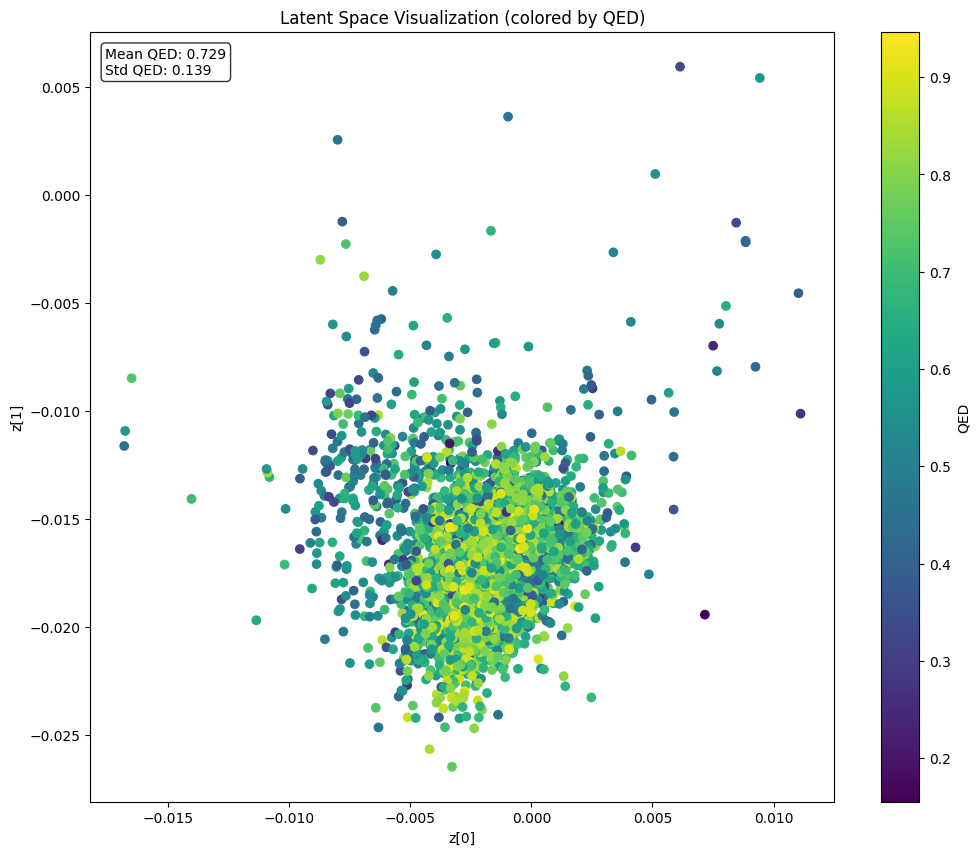


잠재 공간 통계:
Z[0] 범위: [-0.017, 0.011]
Z[1] 범위: [-0.026, 0.006]
Z[0] 평균/표준편차: -0.002 / 0.002
Z[1] 평균/표준편차: -0.017 / 0.002


In [22]:

def plot_latent(model, data, labels, device='cuda'):
    """잠재 공간 시각화"""
    model.eval()  # 평가 모드로 설정

    with torch.no_grad():  # 그래디언트 계산 비활성화
        # 데이터를 텐서로 변환
        adjacency_tensor = torch.FloatTensor(data[0]).to(device)
        feature_tensor = torch.FloatTensor(data[1]).to(device)

        # 배치 크기 설정
        batch_size = 100
        z_means = []

        # 메모리 효율을 위해 배치 단위로 처리
        for i in range(0, len(adjacency_tensor), batch_size):
            batch_adj = adjacency_tensor[i:i+batch_size]
            batch_feat = feature_tensor[i:i+batch_size]

            # 인코더를 통해 잠재 벡터 생성
            z_mean, _ = model.encoder(batch_adj, batch_feat)
            z_means.append(z_mean.cpu().numpy())

    # 결과 합치기
    z_mean = np.concatenate(z_means, axis=0)

    # 시각화
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels, cmap='viridis')
    plt.colorbar(scatter, label='QED')
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.title("Latent Space Visualization (colored by QED)")

    # 통계 정보 추가
    plt.text(0.02, 0.98,
             f'Mean QED: {np.mean(labels):.3f}\n'
             f'Std QED: {np.std(labels):.3f}',
             transform=plt.gca().transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.show()

    # 잠재 공간의 통계 출력
    print("\n잠재 공간 통계:")
    print(f"Z[0] 범위: [{z_mean[:, 0].min():.3f}, {z_mean[:, 0].max():.3f}]")
    print(f"Z[1] 범위: [{z_mean[:, 1].min():.3f}, {z_mean[:, 1].max():.3f}]")
    print(f"Z[0] 평균/표준편차: {z_mean[:, 0].mean():.3f} / {z_mean[:, 0].std():.3f}")
    print(f"Z[1] 평균/표준편차: {z_mean[:, 1].mean():.3f} / {z_mean[:, 1].std():.3f}")

# 사용 예시
def visualize_latent_space(model, dataset, device='cuda'):
    """데이터셋의 잠재 공간 시각화"""
    # 데이터 준비
    adjacency_tensor = dataset.adjacency_tensor[:8000]
    feature_tensor = dataset.feature_tensor[:8000]
    qed_tensor = dataset.qed_tensor[:8000].numpy()

    # 잠재 공간 시각화
    plot_latent(model,
               [adjacency_tensor, feature_tensor],
               qed_tensor,
               device)
visualize_latent_space(model, dataset, device)


## Conclusion

In this example, we combined model architectures from two papers,
"Automatic chemical design using a data-driven continuous representation of
molecules" from 2016 and the "MolGAN" paper from 2018. The former paper
treats SMILES inputs as strings and seeks to generate molecule strings in SMILES format,
while the later paper considers SMILES inputs as graphs (a combination of adjacency
matrices and feature matrices) and seeks to generate molecules as graphs.

This hybrid approach enables a new type of directed gradient-based search through chemical space.

Example available on HuggingFace

| Trained Model | Demo |
| :--: | :--: |
| [![Generic badge](https://img.shields.io/badge/%F0%9F%A4%97%20Model-molecule%20generation%20with%20VAE-black.svg)](https://huggingface.co/keras-io/drug-molecule-generation-with-VAE) | [![Generic badge](https://img.shields.io/badge/%F0%9F%A4%97%20Spaces-molecule%20generation%20with%20VAE-black.svg)](https://huggingface.co/spaces/keras-io/generating-drug-molecule-with-VAE) |
